# **Loading data and packages**

**Libraries import**

In [1]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from ipywidgets import interact
import ipywidgets as widgets
from IPython.display import display
from joblib import load, dump

from sklearn.model_selection import (
    train_test_split, LeaveOneOut, cross_validate, learning_curve, cross_val_predict
)
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, roc_auc_score,
    make_scorer, confusion_matrix, classification_report, roc_curve, auc
)
from sklearn.ensemble import (
    ExtraTreesClassifier, RandomForestClassifier,
    AdaBoostClassifier, GradientBoostingClassifier
)
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC, LinearSVC, NuSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.datasets import make_classification
from sklearn.feature_selection import SelectKBest, f_classif

from imblearn.pipeline import Pipeline
from imblearn.under_sampling import RandomUnderSampler, TomekLinks
from imblearn.over_sampling import RandomOverSampler, SMOTENC, ADASYN
from imblearn.metrics import geometric_mean_score


**Data import**

In [ ]:
# Defining global variables to store the DataFrame
df = pd.DataFrame()
dataset_name = None
X = None
y = None
X_train = None
X_test = None
y_train = None
y_test = None
balancing_method_selected = None

# Function to list CSV files in the directory
def list_csv_files(directory):
    return [f for f in os.listdir(directory) if f.endswith('.csv')]

# Function to load and process the selected dataset with STRATIFIED split
def load_and_process_data(selected_file):
    global df, dataset_name, X, y, X_train, X_test, y_train, y_test
    dataset_name = selected_file
    file_path = os.path.join('..', 'datasets', 'feature_selection', dataset_name)

    if not os.path.exists(file_path):
        print(f"Erro: O arquivo '{file_path}' não foi encontrado.")
        return None

    df = pd.read_csv(file_path)

    # Converting 'Sex' to numeric values
    if 'Sexo' in df.columns:
        df['Sexo'] = df['Sexo'].replace({'M': 0, 'F': 1})

    # Normalizing Age 
    if 'Idade_clinica' in df.columns:
        scaler = MinMaxScaler()
        df['Idade_clinica'] = scaler.fit_transform(df[['Idade_clinica']])

    # Defining X (features) and y (target)
    X = df.drop(columns=['P-HAM/TSP']) 
    y = df['P-HAM/TSP'] 
    
    # Verifying the original class distribution
    print(f"Original class distribution in the entire dataset:")
    print(f"Class 0: {(y == 0).sum()} samples ({((y == 0).sum()/len(y))*100:.1f}%)")
    print(f"Class 1: {(y == 1).sum()} samples ({((y == 1).sum()/len(y))*100:.1f}%)")
    
    # Stratified split 70% for training and 30% for testing
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, 
        test_size=0.3, 
        stratify=y,
        random_state=42
    )
    
    print(f"\nData Loaded and Processed Successfully! Dataset: {dataset_name}")
    print(f"Training set shape: {X_train.shape}")
    print(f"Test set shape: {X_test.shape}")
    
    # Verifying class distribution in training and test sets
    print(f"\nClass distribuition in the training group:")
    print(f"Class 0: {(y_train == 0).sum()} samples ({((y_train == 0).sum()/len(y_train))*100:.1f}%)")
    print(f"Class 1: {(y_train == 1).sum()} samples ({((y_train == 1).sum()/len(y_train))*100:.1f}%)")
    
    print(f"\nClass distribuition in the test groups:")
    print(f"Class 0: {(y_test == 0).sum()} samples ({((y_test == 0).sum()/len(y_test))*100:.1f}%)")
    print(f"Class 1: {(y_test == 1).sum()} samples ({((y_test == 1).sum()/len(y_test))*100:.1f}%)")
    
    return df.head()

# Function to define the selected balancing method
def set_balancing_method(method):
    global balancing_method_selected  
    balancing_method_selected = method  
    print(f"Balancing method selected: {balancing_method_selected}")

# Function to apply the selected balancing method ONLY to training data
def apply_balancing():
    global balancing_method_selected, X_train, y_train
    
    if balancing_method_selected is None:
        print("None balancing method selected. Please select a method first.")
        return X_train, y_train

    if balancing_method_selected == 'Random Over Sampler':
        balancer = RandomOverSampler(random_state=42)
    elif balancing_method_selected == 'SMOTENC':
        # Identify categorical columns
        categorical_features = [i for i, col in enumerate(X_train.columns) if col != 'Idade_clinica']
        balancer = SMOTENC(categorical_features=categorical_features, random_state=42)
    elif balancing_method_selected == 'Random Under Sampler':
        balancer = RandomUnderSampler(random_state=42)
    elif balancing_method_selected == 'Tomek Links':
        balancer = TomekLinks()
    else:
        print(f"Método de balanceamento desconhecido: {balancing_method_selected}")
        return X_train, y_train

    # Applying the balancing method ONLY to training data
    X_res, y_res = balancer.fit_resample(X_train, y_train)
    
    return X_res, y_res

# Define the directory where the CSV files are located
directory = '../datasets/feature_selection/'

# List the CSV files available in the directory
csv_files = list_csv_files(directory)

# Create a selection widget with the files listed
file_selector = widgets.Dropdown(
    options=csv_files,
    description='Select File:'
)

# Create a widget to select the balancing method
balancing_methods = ['Random Over Sampler', 'SMOTENC', 'Random Under Sampler', 'Tomek Links']
method_selector = widgets.Dropdown(
    options=balancing_methods,
    description='Balancing Method:'
)

# Interactive function to load and process the selected CSV file
@interact(selected_file=file_selector)
def load_and_process_selected_file(selected_file):
    result = load_and_process_data(selected_file)
    print("="*60)
    return result

# Interactive function to apply the selected balancing method
@interact(selected_method=method_selector)
def apply_selected_balancing_method(selected_method):
    print("="*60)
    set_balancing_method(selected_method)
    result = apply_balancing()
    print("="*60)
    return result

interactive(children=(Dropdown(description='Select File:', options=('df_Clinic_dataset_cat_3_RUS.csv', 'cat2_d…

interactive(children=(Dropdown(description='Balancing Method:', options=('Random Over Sampler', 'SMOTENC', 'Ra…

#  **Definition of variables, models and metrics**

**Define the variables (X and y) and classifiers** 

In [3]:
# List of model names that have been adjusted
model_names = ['DT', 'GB', 'LR', 'MLP', 'NB', 'RF', 'SVM', 'KNN', 'AB', 'LSVM']

# Directory where models and results are saved
model_dir = '../models/'

# Dictionary to store loaded templates
classifiers = {}

# Function for loading templates
def load_model(model_name):
    model_path = os.path.join(model_dir, f'best_{model_name}_model.joblib')

    if os.path.exists(model_path):
        # Load the model
        model = load(model_path)

        if isinstance(model, SVC):
            model.probability = True

        # Add the model to the classifiers dictionary using the corresponding name
        classifiers[model_name] = model

        print(f'Model {model_name} loaded with success.')
        print(f'  - Model trained on {X_train.shape[0]} samples (70% of data)')
        print(f'  - Ready for validation on {X_test.shape[0]} test samples (30% isolated)')
    else:
        print(f'Model {model_name} not found.')

# Iterate over all the model names and load them
for model_name in model_names:
    load_model(model_name)

# Function to make predictions on the isolated test set
def predict_on_test_set():
    results = {}
    
    for model_name, model in classifiers.items():
        try:
            # Making predictions on the test set (30% isolated)
            y_pred = model.predict(X_test)
            y_proba = model.predict_proba(X_test)[:, 1] if hasattr(model, 'predict_proba') else None
            
            results[model_name] = {
                'predictions': y_pred,
                'probabilities': y_proba
            }
            
            print(f"{model_name}: Previsions made in {X_test.shape[0]} samples of the test set")
            
        except Exception as e:
            print(f"Error in {model_name}: {e}")
    
    return results

# Function to evaluate models on the isolated test set
def evaluate_on_test_set():
    results = {}
    
    for model_name, model in classifiers.items():
        try:
            # Make predictions on the test set
            y_pred = model.predict(X_test)
            
            # Calculate metrics
            accuracy = accuracy_score(y_test, y_pred)
            precision = precision_score(y_test, y_pred, zero_division=0)
            recall = recall_score(y_test, y_pred, zero_division=0)
            f1 = f1_score(y_test, y_pred, zero_division=0)
            gmean = geometric_mean_score(y_test, y_pred)
            
            results[model_name] = {
                'accuracy': accuracy,
                'precision': precision,
                'recall': recall,
                'f1': f1,
                'gmean': gmean,
                'predictions': y_pred
            }
            
            print(f"{model_name}: G-mean = {gmean:.4f}, Accuracy = {accuracy:.4f}")
            
        except Exception as e:
            print(f"Error in evaluation of {model_name}: {e}")
    
    return results


Model DT loaded with success.
  - Model trained on 180 samples (70% of data)
  - Ready for validation on 78 test samples (30% isolated)
Model GB loaded with success.
  - Model trained on 180 samples (70% of data)
  - Ready for validation on 78 test samples (30% isolated)
Model LR loaded with success.
  - Model trained on 180 samples (70% of data)
  - Ready for validation on 78 test samples (30% isolated)
Model MLP loaded with success.
  - Model trained on 180 samples (70% of data)
  - Ready for validation on 78 test samples (30% isolated)
Model NB loaded with success.
  - Model trained on 180 samples (70% of data)
  - Ready for validation on 78 test samples (30% isolated)
Model RF loaded with success.
  - Model trained on 180 samples (70% of data)
  - Ready for validation on 78 test samples (30% isolated)
Model SVM loaded with success.
  - Model trained on 180 samples (70% of data)
  - Ready for validation on 78 test samples (30% isolated)
Model KNN loaded with success.
  - Model train

In [4]:
import numpy as np
import pandas as pd
from sklearn.metrics import (accuracy_score, precision_score, recall_score, 
                             f1_score, roc_auc_score)
from imblearn.metrics import geometric_mean_score

# List to store the results
results = []

print("="*60)
print("FINAL VALIDATION ON ISOLATED TEST SET (30%)")
print("="*60)
print(f"Test set size: {X_test.shape[0]} samples")
print(f"Class distribution in test set: {np.bincount(y_test)}")
print("="*60)

# Iterating on the classifiers
for clf_name, clf in classifiers.items():
    try:
        # Make predictions on the isolated test set (30%)
        y_pred_test = clf.predict(X_test)
        
        # To SVM models, get probabilities if available
        if hasattr(clf, 'predict_proba'):
            y_prob_test = clf.predict_proba(X_test)[:, 1]
        elif hasattr(clf, "decision_function"):
            y_prob_test = clf.decision_function(X_test)
            # Normalize to [0, 1]
            y_prob_test = (y_prob_test - y_prob_test.min()) / (y_prob_test.max() - y_prob_test.min())
        else:
            y_prob_test = np.zeros_like(y_pred_test)
        
        # Calculate metrics
        accuracy = accuracy_score(y_test, y_pred_test)
        precision = precision_score(y_test, y_pred_test, zero_division=0)
        recall = recall_score(y_test, y_pred_test, zero_division=0)
        f1 = f1_score(y_test, y_pred_test, zero_division=0)
        gmean = geometric_mean_score(y_test, y_pred_test)
        
        # Calculate ROC AUC only if there are both classes in y_test
        if len(np.unique(y_test)) > 1 and y_prob_test is not None:
            roc_auc = roc_auc_score(y_test, y_prob_test)
        else:
            roc_auc = np.nan
        
        # Adding results
        results.append({
            'classifier': clf_name,
            'Accuracy': accuracy,
            'Precision': precision,
            'Recall': recall,
            'F1': f1,
            'G-Mean': gmean,
            'ROC AUC': roc_auc,
            'Test Samples': X_test.shape[0],
            'Class 0': (y_test == 0).sum(),
            'Class 1': (y_test == 1).sum()
        })
        
        print(f"✅ {clf_name}:")
        print(f"   Accuracy: {accuracy:.4f}, G-Mean: {gmean:.4f}, ROC AUC: {roc_auc:.4f}")
        
    except Exception as e:
        print(f"❌ Erro na validação de {clf_name}: {e}")
        results.append({
            'classifier': clf_name,
            'Accuracy': np.nan,
            'Precision': np.nan,
            'Recall': np.nan,
            'F1': np.nan,
            'G-Mean': np.nan,
            'ROC AUC': np.nan,
            'Test Samples': X_test.shape[0],
            'Class 0': (y_test == 0).sum(),
            'Class 1': (y_test == 1).sum()
        })

# Convert results to DataFrame
results_df = pd.DataFrame(results)

# Display the results
print("="*60)
print("Results on the isolated test set (30%):")
print("="*60)
print(f"Total of evaluated models: {len(results_df)}")
print(f"Test sampes utilized: {X_test.shape[0]}")
print("="*60)

# Re-order columns for better visualization
column_order = ['classifier', 'Accuracy', 'Precision', 'Recall', 'F1', 'G-Mean', 'ROC AUC', 'Test Samples', 'Class 0', 'Class 1']
results_df = results_df[column_order]

print(results_df.round(4))

# Save results in CSV
results_csv_path = '../models/final_test_results.csv'
results_df.to_csv(results_csv_path, index=False)
print(f"✅ Results save at: {results_csv_path}")

print("="*60)
print("Analysis of the Test Set:")
print("="*60)
print(f"Total of samples: {X_test.shape[0]}")
print(f"Class 0: {(y_test == 0).sum()} ({(y_test == 0).sum()/X_test.shape[0]*100:.1f}%)")
print(f"Class 1: {(y_test == 1).sum()} ({(y_test == 1).sum()/X_test.shape[0]*100:.1f}%)")
print("="*60)

FINAL VALIDATION ON ISOLATED TEST SET (30%)
Test set size: 78 samples
Class distribution in test set: [60 18]
✅ DT:
   Accuracy: 0.7949, G-Mean: 0.7454, ROC AUC: 0.7731
✅ GB:
   Accuracy: 0.8205, G-Mean: 0.7601, ROC AUC: 0.7963
✅ LR:
   Accuracy: 0.7564, G-Mean: 0.7441, ROC AUC: 0.8500
✅ MLP:
   Accuracy: 0.7692, G-Mean: 0.7522, ROC AUC: 0.8306
✅ NB:
   Accuracy: 0.7308, G-Mean: 0.7466, ROC AUC: 0.8454
✅ RF:
   Accuracy: 0.7436, G-Mean: 0.7360, ROC AUC: 0.8259
✅ SVM:
   Accuracy: 0.7436, G-Mean: 0.0000, ROC AUC: 0.7264
✅ KNN:
   Accuracy: 0.7692, G-Mean: 0.7303, ROC AUC: 0.8551
✅ AB:
   Accuracy: 0.7821, G-Mean: 0.7379, ROC AUC: 0.8148
✅ LSVM:
   Accuracy: 0.7436, G-Mean: 0.7360, ROC AUC: 0.8509
Results on the isolated test set (30%):
Total of evaluated models: 10
Test sampes utilized: 78
  classifier  Accuracy  Precision  Recall      F1  G-Mean  ROC AUC  \
0         DT    0.7949     0.5455  0.6667  0.6000  0.7454   0.7731   
1         GB    0.8205     0.6000  0.6667  0.6316  0.7601   

# **Model evaluation**

Heatmap plot

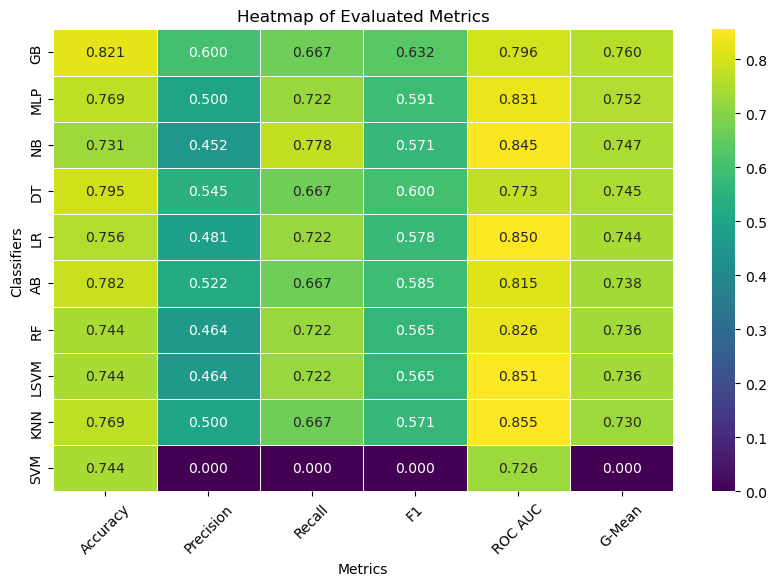

In [5]:
# Defining the names of the evaluation metrics
metric_names = ['Accuracy', 'Precision', 'Recall', 'F1', 'ROC AUC', 'G-Mean']

# Selecting the metrics for the heatmap and configuring the index
heatmap_df = results_df[metric_names].set_index(results_df['classifier'])

# Sorting the DataFrame by G-Mean value
heatmap_df = heatmap_df.sort_values(by='G-Mean', ascending=False)

# Plotting the heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(heatmap_df, cmap='viridis', annot=True, fmt=".3f", linewidths=.5)
plt.title('Heatmap of Evaluated Metrics')
plt.xlabel('Metrics')
plt.ylabel('Classifiers')
plt.xticks(rotation=45)
plt.savefig('../results/heatmap.jpeg')
plt.show()


Learning Curves

Plotting the learning curves:
Plotting Learning Curves using TEST set (30%) for validation
Train: 180 samples (70%)
Validation: 78 samples (30%)
Plotting the curve for: DT


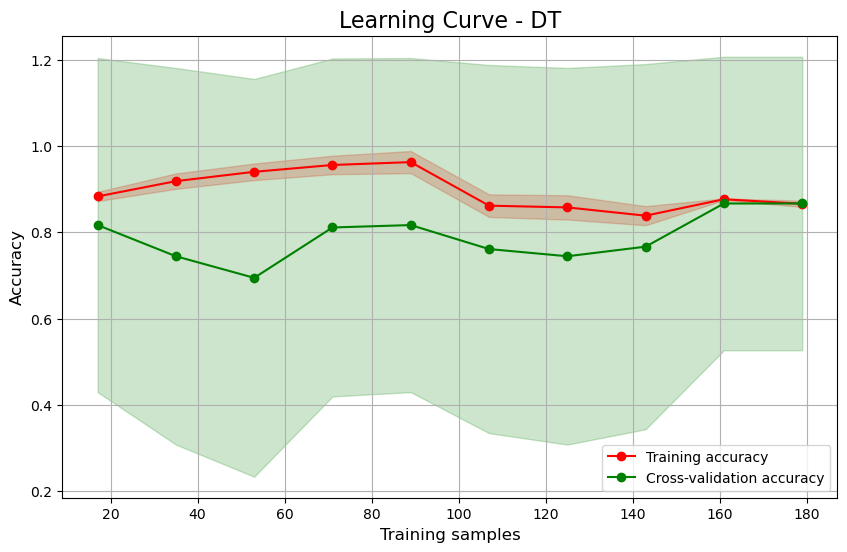

✅ Curve saved at: ../results/learning_curve_DT.png
Plotting the curve for: GB


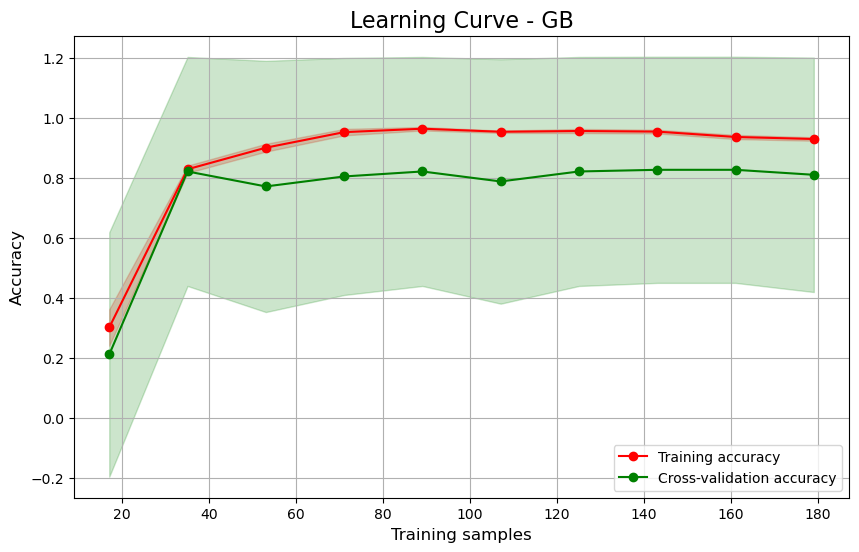

✅ Curve saved at: ../results/learning_curve_GB.png
Plotting the curve for: LR


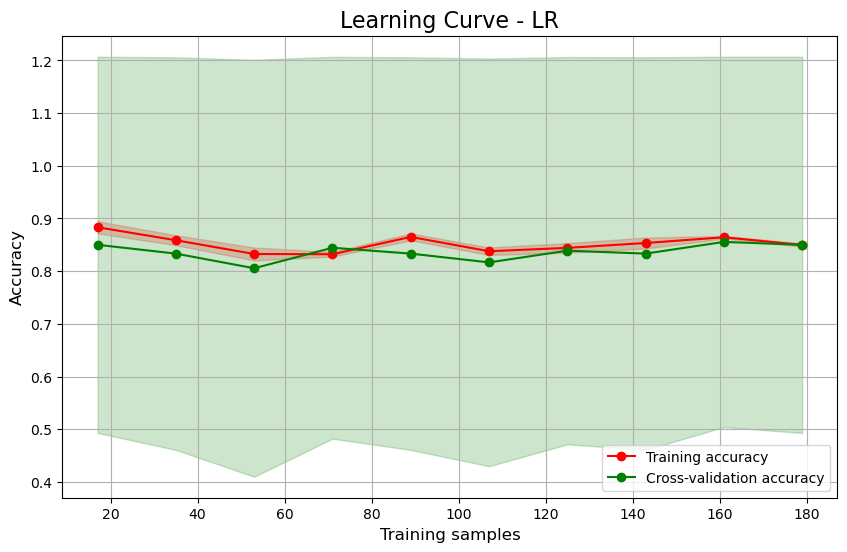

✅ Curve saved at: ../results/learning_curve_LR.png
Plotting the curve for: MLP


/home/matheus_bomfim/anaconda3/envs/MBL2_ML/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1406) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/matheus_bomfim/anaconda3/envs/MBL2_ML/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1406) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/matheus_bomfim/anaconda3/envs/MBL2_ML/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1406) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/matheus_bomfim/anaconda3/envs/MBL2_ML/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1406) reached and the 

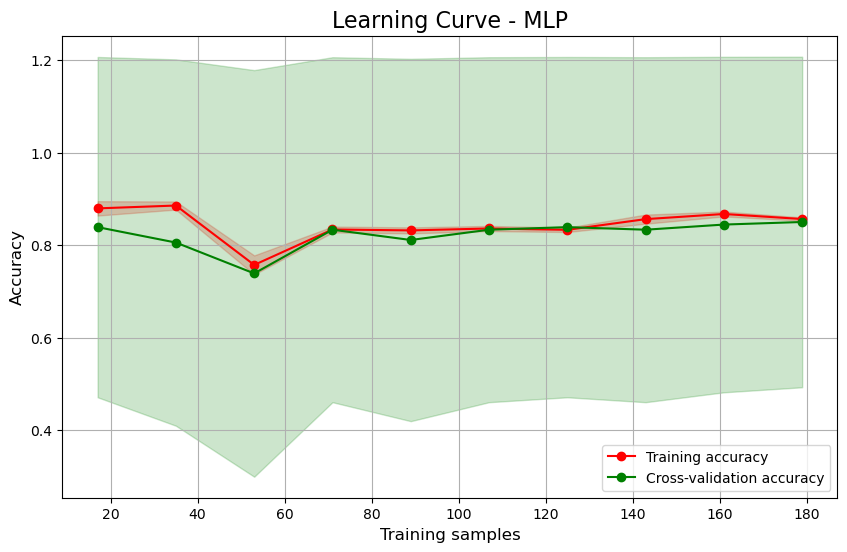

✅ Curve saved at: ../results/learning_curve_MLP.png
Plotting the curve for: NB


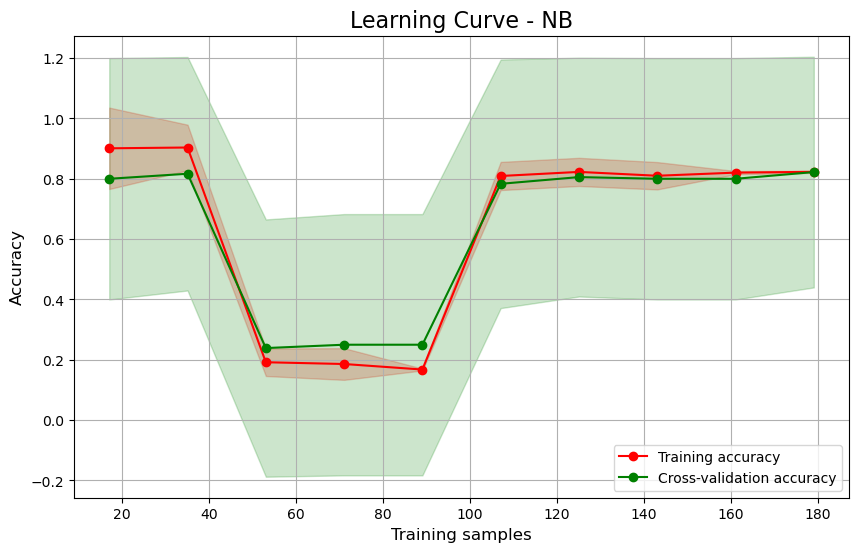

✅ Curve saved at: ../results/learning_curve_NB.png
Plotting the curve for: RF


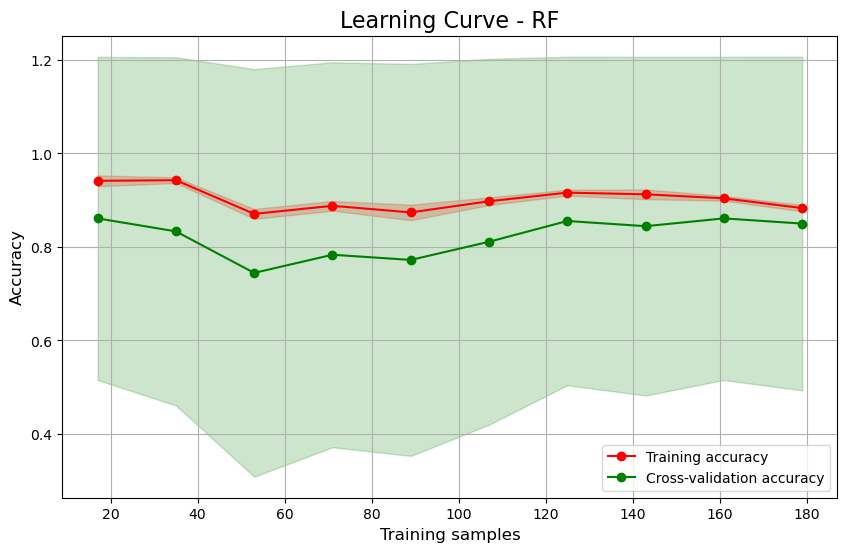

✅ Curve saved at: ../results/learning_curve_RF.png
Plotting the curve for: SVM


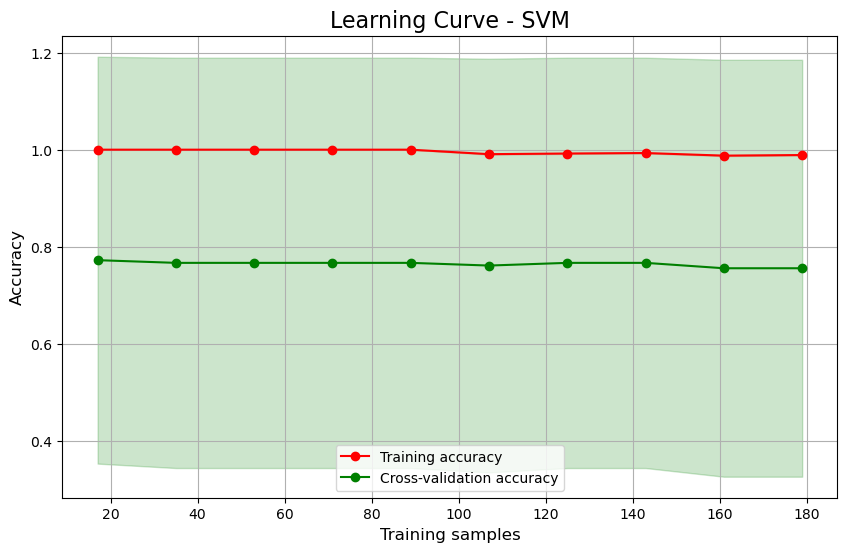

✅ Curve saved at: ../results/learning_curve_SVM.png
Plotting the curve for: KNN


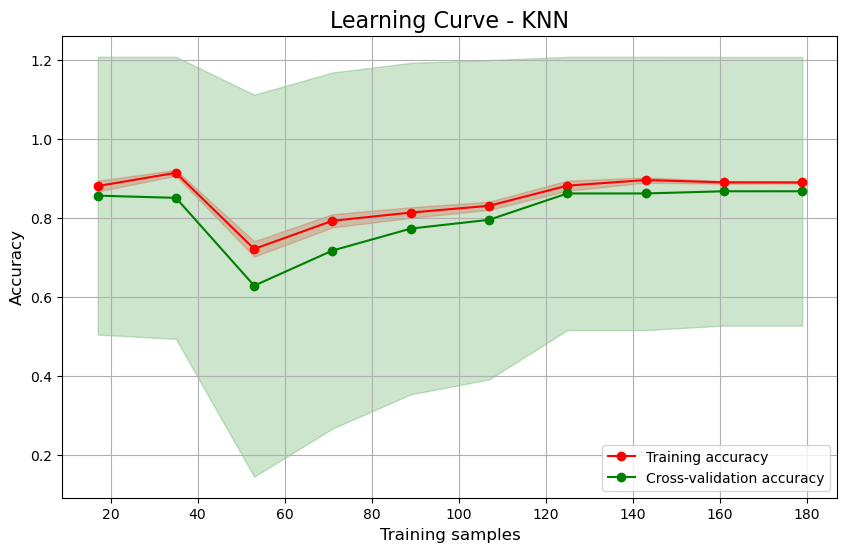

✅ Curve saved at: ../results/learning_curve_KNN.png
Plotting the curve for: AB


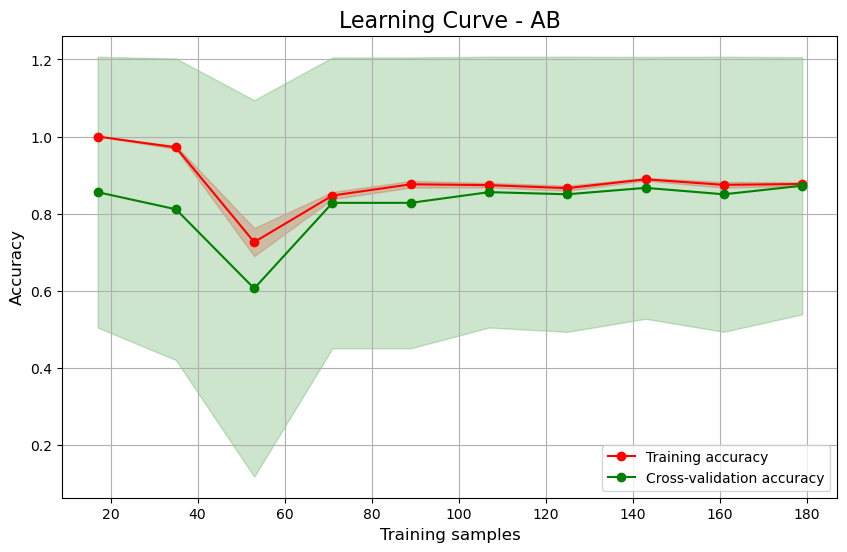

✅ Curve saved at: ../results/learning_curve_AB.png
Plotting the curve for: LSVM


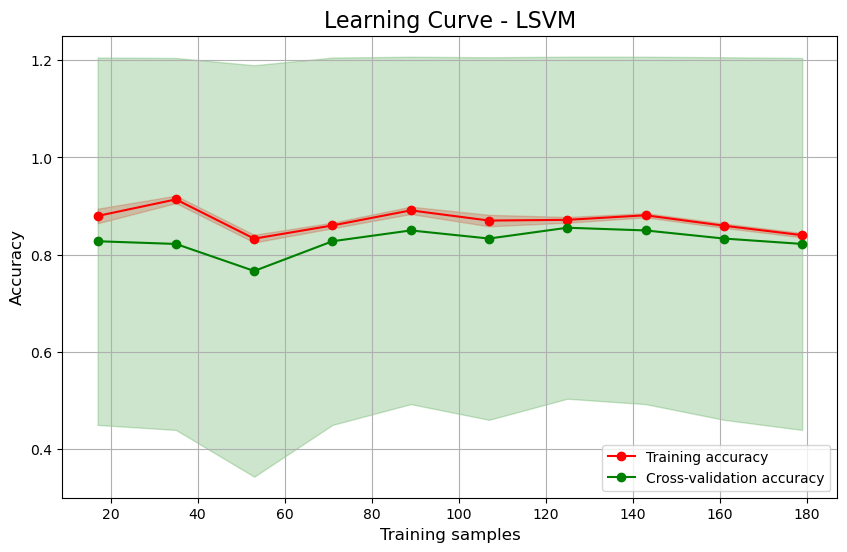

✅ Curve saved at: ../results/learning_curve_LSVM.png


In [6]:
from sklearn.model_selection import learning_curve
import matplotlib.pyplot as plt
import os
from sklearn.exceptions import ConvergenceWarning
import warnings

warnings.filterwarnings("ignore", category=ConvergenceWarning)

# Function to plot learning curves using the TEST set (30%) for validation
def plot_learning_curve(classifiers, train_sizes=np.linspace(0.1, 1.0, 10)):
    results_dir = '../results/' 
    
    print("="*60)
    print("Plotting Learning Curves using TEST set (30%) for validation")
    print("="*60)
    print(f"Train: {X_train.shape[0]} samples (70%)")
    print(f"Validation: {X_test.shape[0]} samples (30%)")
    print("="*60)

    for name, estimator in classifiers.items():
        print(f"Plotting the curve for: {name}")
        
        # Get learning curve data using TEST set for validation
        train_sizes_abs, train_scores, test_scores = learning_curve(
            estimator, 
            X_train,  
            y_train,   
            train_sizes=train_sizes, 
            cv=LeaveOneOut(),  
            scoring='accuracy', 
            n_jobs=-1
        )

        # Calculate means and standard deviations
        train_scores_mean = np.mean(train_scores, axis=1)
        train_scores_std = np.std(train_scores, axis=1)
        test_scores_mean = np.mean(test_scores, axis=1)
        test_scores_std = np.std(test_scores, axis=1)

        # Plot the learning curves
        plt.figure(figsize=(10, 6))
        plt.title(f'Learning Curve - {name}', fontsize=16)
        plt.xlabel("Training samples", fontsize=12)
        plt.ylabel("Accuracy", fontsize=12)

        # Plot training data and fill between for standard deviation
        plt.plot(train_sizes_abs, train_scores_mean, 'o-', label="Training accuracy", color="r")
        plt.fill_between(train_sizes_abs, 
                         train_scores_mean - train_scores_std, 
                         train_scores_mean + train_scores_std, 
                         alpha=0.2, color="r")

        # Plot test data and fill between for standard deviation
        plt.plot(train_sizes_abs, test_scores_mean, 'o-', label="Cross-validation accuracy", color="g")
        plt.fill_between(train_sizes_abs, 
                         test_scores_mean - test_scores_std, 
                         test_scores_mean + test_scores_std, 
                         alpha=0.2, color="g")

        # Show legend and grid
        plt.legend(loc="best")
        plt.grid(True)

        # Save the plot
        plot_filename = os.path.join(results_dir, f'learning_curve_{name}.png')
        plt.savefig(plot_filename, dpi=300, bbox_inches='tight')
        plt.show()
        
        print(f"✅ Curve saved at: {plot_filename}")

# Execute the function
print("Plotting the learning curves:")
plot_learning_curve(classifiers)


Confusion matrix

Model DT loaded with success.
  - Model trained on 180 samples (70% of data)
  - Ready for validation on 78 test samples (30% isolated)
Model GB loaded with success.
  - Model trained on 180 samples (70% of data)
  - Ready for validation on 78 test samples (30% isolated)
Model LR loaded with success.
  - Model trained on 180 samples (70% of data)
  - Ready for validation on 78 test samples (30% isolated)
Model MLP loaded with success.
  - Model trained on 180 samples (70% of data)
  - Ready for validation on 78 test samples (30% isolated)
Model NB loaded with success.
  - Model trained on 180 samples (70% of data)
  - Ready for validation on 78 test samples (30% isolated)
Model RF loaded with success.
  - Model trained on 180 samples (70% of data)
  - Ready for validation on 78 test samples (30% isolated)
Model SVM loaded with success.
  - Model trained on 180 samples (70% of data)
  - Ready for validation on 78 test samples (30% isolated)
Model KNN loaded with success.
  - Model train

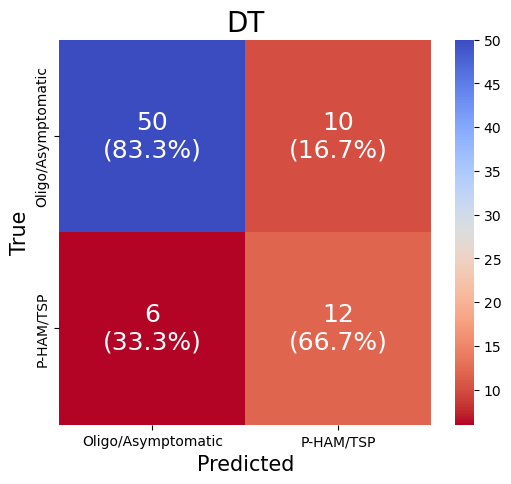

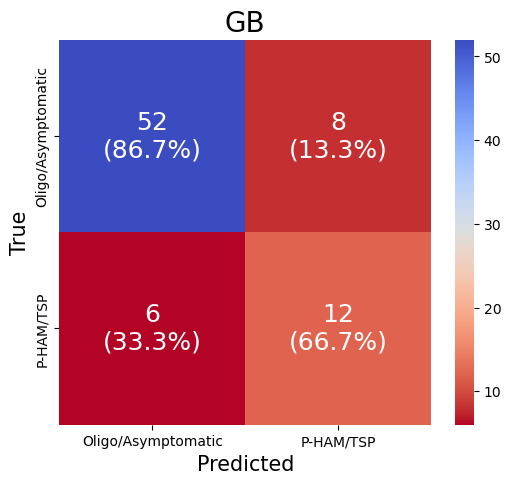

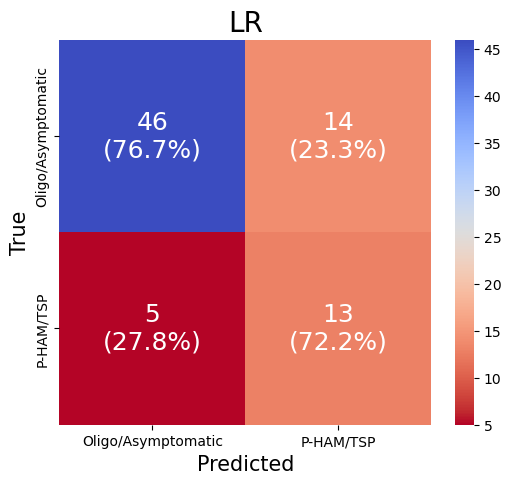

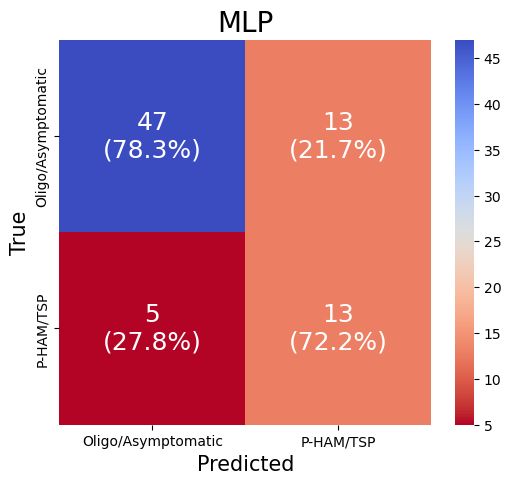

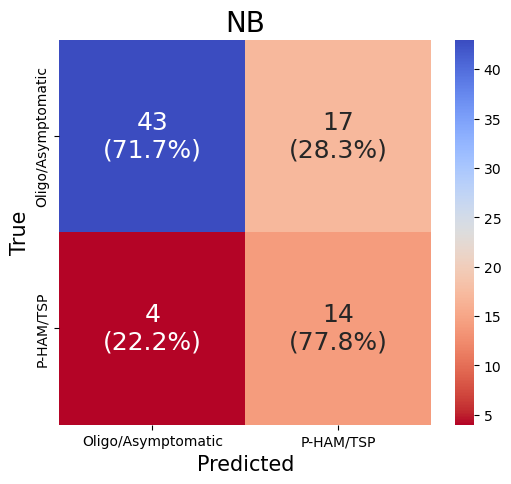

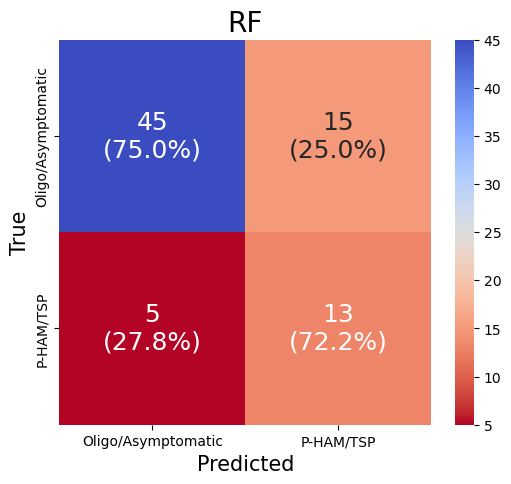

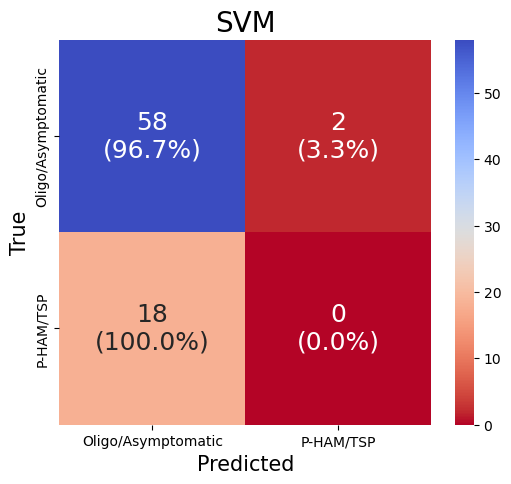

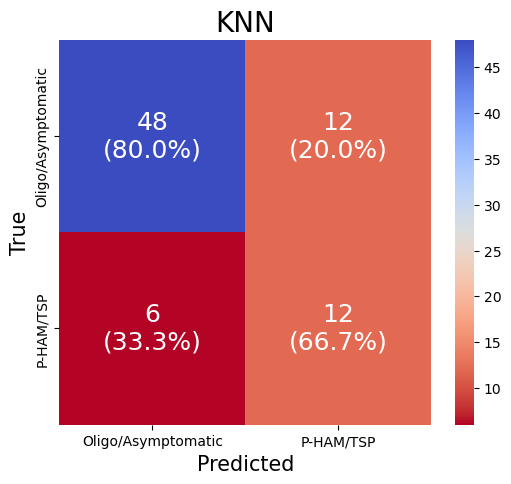

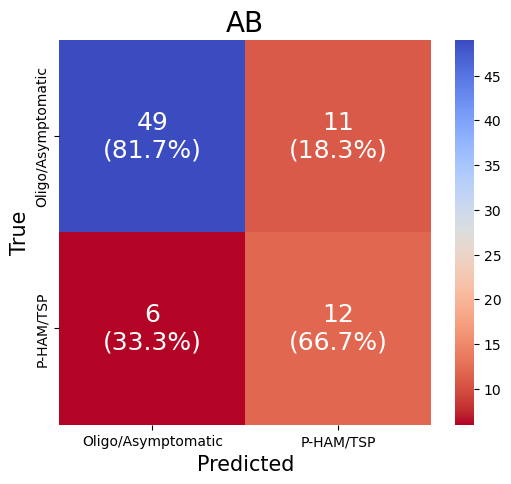

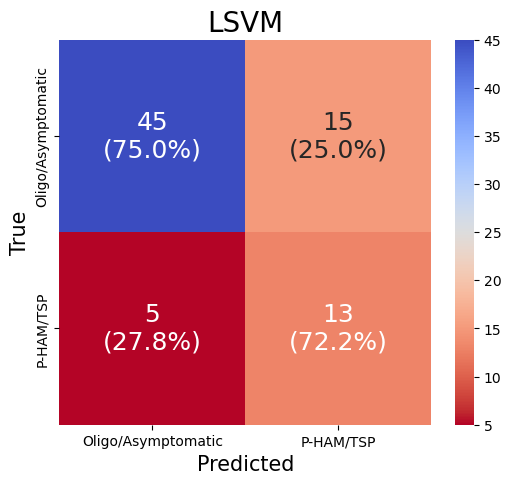

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Function to plot confusion matrix with percentages per row
def plot_confusion_matrix(model_name, X_test, y_test):
    model = classifiers[model_name]
    
    # Make predictions no conjunto de validação X_test
    y_preds = model.predict(X_test)
    
    # Calculate the confusion matrix
    cm = confusion_matrix(y_test, y_preds)
    
    # Convert confusion matrix to percentages per row
    cm_percent = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100
    cm_percent = np.nan_to_num(cm_percent)  # Handle divisions by zero
    
    # Define custom labels
    labels = ['Oligo/Asymptomatic', 'P-HAM/TSP']

    # Create annotations combining absolute values and percentages
    annot = np.empty_like(cm).astype(str)
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            annot[i, j] = f'{cm[i, j]}\n({cm_percent[i, j]:.1f}%)'

    # Plot the heatmap
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=annot, fmt='', cmap='coolwarm_r',
            xticklabels=labels, yticklabels=labels,
            annot_kws={"size": 18})  # Aumenta o tamanho das anotações
    plt.xlabel('Predicted', fontsize=15)
    plt.ylabel('True', fontsize=15)
    plt.title(f'{model_name}', fontsize=20)

    # Save the picture
    plt.savefig(f'../results/{model_name}_confusion_matrix.jpeg')
    plt.show()


# Iterate over all the model names and load them
for model_name in model_names:
    load_model(model_name)

# Plot the confusion matrix for each loaded model using the validation/test set
for model_name in model_names:
    if model_name in classifiers:  # Only plot if the model is loaded successfully
        plot_confusion_matrix(model_name, X_test, y_test)
